In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
os.sys.path.append('../utils') #To load master_configuration.yaml
from readYAML import read_config_file #To load in master configuration

### Aside: let's begin by setting up our environment by reading master_configuration.yaml

Conf will be used later on when we get into generating images and labels for training YOLO. I've set up this configuration environment so the user doesn't have to find specific notebook cells to edit. Instead, you can just edit master_configuration.yaml. You can feel free to expand master_configuration.yaml as needed.

In [2]:
'''TODO for Jeff: integrate convenience functions like this into the readYAML.py'''

def load_configuration(file_path):
    
    #Read yoloConf field of yaml file
    conf = read_config_file(file_path)['yoloConf']
    
    #Raise error if there's noise because there isn't supposed to be for this tutorial :-)
    if conf['noise'] == True:
        raise ValueError("For this tutorial we will not be working with noisy simulation. Please change the 'noise' field to False in master_configuration.yaml")
    #Check the Ultralytics fields in master_configuration.yaml based on if we're using linear or log scale images
    else:
        if conf['log_scale'] == True:
            Ultconf = read_config_file(file_path)['log_scale']
        else:
            Ultconf = read_config_file(file_path)['linear_scale']
    #Append the correct ultralytics training information to our yolo configuration
    conf.update(Ultconf)
    return conf

In [3]:
conf = load_configuration('../master_configuration.yaml')

In [4]:
'''Conf is a dictionary'''
conf

{'use_pretrained': True,
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'numKeyPoints': 7,
 'GPU': True,
 'project': '../models/raw_linear',
 'yoloConfigFile': '../configs/keypoint.yaml',
 'suffix': ''}

### Okay, now the processing begins. Let's start by loading simulation

In [5]:
'''Load simulated ERs'''
ERs = pd.read_feather('../data/raw_simulation/ERs_cont_spectrum_correctE.feather')

### Now we approximate the head as the point with highest intensity and use the truth simulated vertex as the tail. These are our track endpoints and we will use these as boundaries to define our keypoint training labels

In [6]:
def find_head(df,i):
    tmp = df.iloc[i]
    indices = pd.Series(tmp['q']).nlargest(3).index.to_numpy()
    return np.median(tmp['x'][indices]),np.median(tmp['y'][indices])

In [7]:
xs = []
ys = []
for i in tqdm(range(0,len(ERs))):
    x,y = find_head(ERs,i)
    xs.append(x)
    ys.append(y)

100%|████████████████████████████████████████████████████████| 10500/10500 [00:04<00:00, 2536.73it/s]


In [8]:
ERs['xhead'] = xs
ERs['yhead'] = ys

### To keep "nice" ER tracks, we can cut on the distance between the track vertex and track head which I'm calling 'htlength' which is short for head/tail length. 
This isn't something we generally want to do, but I'm doing this so we can automatically generate decent-looking keypoint sets easily. In general we want something that works even for ERs following the most complicated trajectories, but this is just a demonstration

In [9]:
ERs['htlength'] = np.sqrt((ERs['xvtx']-ERs['xhead'])**2+(ERs['yvtx']-ERs['yhead'])**2)

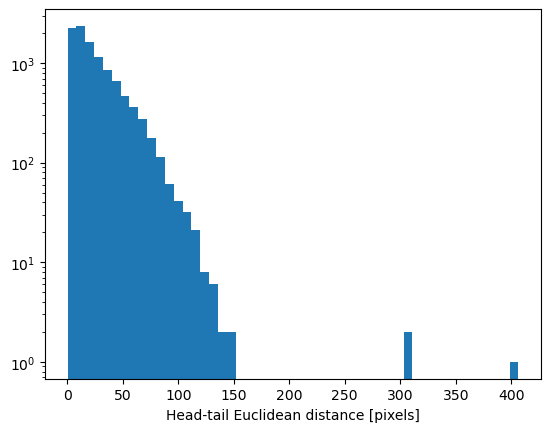

'Most tracks have short head/tail lengths. We"re going to consider longer lengths, \nas trajectories are less ambiguous for these'

In [10]:
'''Whenever you define a new variable that you can make cuts on, it"s generally good practice
to look at the distribution of the variable'''

plt.hist(ERs['htlength'],bins=51)
plt.xlabel('Head-tail Euclidean distance [pixels]')
plt.yscale('log')
plt.show()

'''Most tracks have short head/tail lengths. We"re going to consider longer lengths, 
as trajectories are less ambiguous for these'''

### Centering tracks to make rotations easier. This step isn't strictly necessary but I'm doing it for this example

In [11]:
'''Center all tracks. First shift the vertex and head columns, then do the entire track'''
ERs['xvtx'] = ERs['xvtx']-ERs['x'].apply(lambda x: x.min())+1024
ERs['yvtx'] = ERs['yvtx']-ERs['y'].apply(lambda x: x.min())+1152//2
ERs['xhead'] = ERs['xhead']-ERs['x'].apply(lambda x: x.min())+1024
ERs['yhead'] = ERs['yhead']-ERs['y'].apply(lambda x: x.min())+1152//2

ERs['x'] = ERs['x'].apply(lambda x: x-x.min()+1024)
ERs['y'] = ERs['y'].apply(lambda x: x-x.min()+1152//2)

# This method is what we're using to generate simulated key points.
**These keypoints are what we will use to label our data to train YOLO. Any supervised learning task requires to be trained on labeled data. For this example, I thought it would be better to automate the key point generation, rather than making us label a ton of data by hand.**

You might be wondering, "wait, if we can automatically generate key points, then what's the point of using YOLO?" Well, the point of training YOLO is to come up with a general way of identifying key points. The method we're using here works because (a) we don't have noise to begin with, and most importantly, (b) we know the vertex (tail) of simulated ER tracks. Knowledge of the vertex is needed for the method below to work and in general, the tail of ERs is difficult to find in real data using first principles approaches. So, we'll use this method to generate sets of key points to train YOLO on, then we'll train YOLO, and then we'll test it's predictions on data it wasn't trained on and see how it compares to this method.

In [12]:
import numpy as np
from scipy.sparse import coo_matrix

class generate_keypoints:
    '''Class takes a sparse image, rotates it so the head and tail are vertically aligned.
    Then it partitions the interval between the head and tail into n_outputs + 2 equally spaced subdivisions
    and records the (x',y') coordinate of either (a) the max intensity [if the mode parameter is set to 'max']
    or (b), the median (x',y') over the 9 most intense pixels in each partition. The code then rotates the set of
    (x',y')s back to the original image orientation, which are our keypoints!'''
    
    def __init__(self,df,i,n_outputs=1,dim=(2048,1152),mode='max'):
        if mode.lower() != 'max' and mode.lower() != 'median':
            raise ValueError("mode must be 'max' or 'median'")
        self.mode = mode.lower()
        evt = df.iloc[i]
        self.n_outputs = n_outputs
        self.center_x = dim[1] // 2
        self.center_y = dim[0] // 2
        self.col = evt['x'].astype('int')
        self.row = evt['y'].astype('int')
        self.data = evt['q']
        self.head = np.array([evt['xhead'],evt['yhead']])
        self.tail = np.array([evt['xvtx'],evt['yvtx']])
        self.rotation_angle = self.get_rotation_angle()
        
        '''Rotation matrices, backward rotation is used to translate track segments back to original'''
        self.forward_rotation = self.generate_rotation_matrix(self.rotation_angle)
        self.reverse_rotation = np.linalg.inv(self.forward_rotation)
        
        '''Rotate head and tail to rotated space'''
        self.rothead = self.rotate_coord(self.head[::-1],self.forward_rotation)
        self.rottail = self.rotate_coord(self.tail[::-1],self.forward_rotation)
        
        #print(self.rotate_coord(self.rothead,self.reverse_rotation))
        '''Generate rotated sparse image'''
        self.rot_im = self.rotate_sparse_image()
        
        '''Get segmented coordinates in rotated space'''
        self.rot_segments = np.array(self.get_segment_coordinates()).T
        self.segments = []
        self.segments.append((evt['xvtx'],evt['yvtx']))
        for coord in self.rot_segments:
            self.segments.append(self.rotate_coord(coord,self.reverse_rotation)[::-1])
        self.segments.append((evt['xhead'],evt['yhead']))
    def get_rotation_angle(self):
        vec = np.array([self.head[0]-self.tail[0],self.head[1]-self.tail[1]])
        theta = np.arctan2(vec[1],vec[0])
        return theta

    def generate_rotation_matrix(self,theta):
        cos_angle = np.cos(theta)
        sin_angle = np.sin(theta)
        
        rotation_matrix = np.array([
            [cos_angle, sin_angle],
            [-sin_angle, cos_angle]
        ])
            
        return rotation_matrix

    def rotate_sparse_image(self):
        sparse_matrix = coo_matrix((self.data, (self.row, self.col)), shape=(1152,2048))
        # Center of the image

        # Translate coordinates to origin
        translated_x = self.col - self.center_x
        translated_y = self.row - self.center_y

        # Apply rotation
        new_coords = np.dot(self.forward_rotation, np.array([translated_x, translated_y]))

        new_x = np.round(new_coords[0] + self.center_x).astype('int')
        new_y = np.round(new_coords[1] + self.center_y).astype('int')

        # Filter out-of-bounds coordinates
        valid_mask = (new_x >= 0) & (new_x < sparse_matrix.shape[1]) & (new_y >= 0) & (new_y < sparse_matrix.shape[0])
        new_x = new_x[valid_mask]
        new_y = new_y[valid_mask]
        new_data = self.data[valid_mask]

        # Create the rotated sparse matrix
        rotated_sparse_matrix = coo_matrix((new_data, (new_y, new_x)), shape=sparse_matrix.shape)
        return rotated_sparse_matrix.toarray().T
    
    def rotate_coord(self,coord,rot):
        original_coordinate = coord

        # Translate coordinate to origin
        translated_x = original_coordinate[1] - self.center_x
        translated_y = original_coordinate[0] - self.center_y

        # Apply rotation
        new_coord = np.dot(rot, np.array([translated_x, translated_y]))

        # Translate back to the original coordinate system
        new_coordinate = (new_coord[1] + self.center_y, new_coord[0] + self.center_x)
        return new_coordinate
    
    def get_segment_coordinates(self):
        n_partitions = self.n_outputs+2
        y_segments = np.linspace(self.rottail[1],self.rothead[1],n_partitions)[1:-1]
        x_segments = []
        for seg in y_segments:
            if self.mode == 'max':
                x_coord = np.median(np.where(self.rot_im[int(np.round(seg)),:] == self.rot_im[int(np.round(seg)),:].max())[0])
            elif self.mode == 'median':
                indices = pd.Series(self.rot_im[int(np.round(seg)),:]).nlargest(9).index.to_numpy()
                x_coord = np.median(indices)
            x_segments.append(x_coord)
        x_segments = np.array(x_segments)
        if np.mean(x_segments) != 575.5 and np.mean(x_segments) != 4:
            return x_segments,y_segments
        else:
            raise ValueError("Bad rotation")

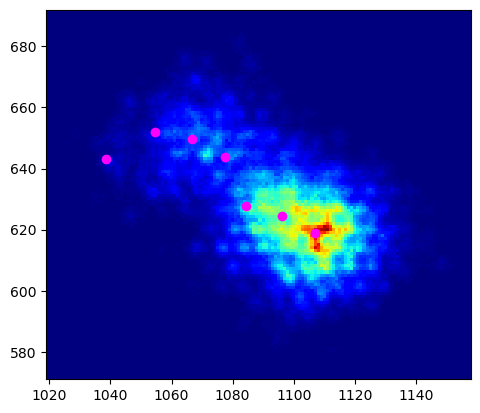

In [15]:
'''Let"s test the output of this method. We"ll run it on one event and then plot the output'''

#We're generating keypoints for track 11 of the set of ERs with htlength > 11
#Remember conf['numKeyPoints'] is the total number of keypoints in our sample which includes the head and tail
#We therefore generate conf['numKeyPoints']-2 points
#Feel free to play around with the n_outputs parameter here but make sure you set the desired number of
#key points in master_configuration.yaml when performing a study
a = generate_keypoints(ERs.query('htlength > 50'),i = 11,n_outputs = conf['numKeyPoints']-2,mode = 'median') #can change 'median' to 'max' to test what happens

'''Our simulation has track coordinates stored as sparse arrays, meaning it only saves the coordinates
of pixels with non-zero content. To form images our of sparse arrays you can just histogram the sparse
array content, setting the bins and range to be appropriate for the camera'''
im = np.histogram2d(a.col,a.row,weights=a.data,bins=(2048,1152),range=((0,2048),(0,1152)))[0].T

#plot image
plt.imshow(im,cmap='jet')
#Zoom into track
plt.xlim(a.col.min()-5,a.col.max()+5)
plt.ylim(a.row.min()-5,a.row.max()+5)

#Plot segments we generated
for seg in a.segments: #a.segments are the output of generate_keypoints
    plt.plot(seg[0],seg[1],'o',color='magenta')

plt.xlim()
plt.show()

### Now let's process all events with 50 < htlength < 200. This cut gives us the longer ER tracks but omits the exceptionally long outliers we saw in the previous histogram

In [16]:
'''There"s an apparent bug in the keypoint generation code where certain kinds of rotations mess things up.
I"ve figured out how to flag these, but haven"t figured out how to fix this. Nevertheless, since this is
meant to be a minimal working example, we won"t sweat this. Because of this bug, there will be a preferred 
direction in the trajectories that do generate. Generally speaking training on a preferred direction will 
bias a machine learning model which we don"t want.'''

ERs = ERs.query('200 > htlength > 50')
ERs.index = [i for i in range(0,len(ERs))]

good_indices = []
coords = {} #dictionary filled with keypoint tuples
for i in range(0,len(a.segments)):
    coords[i] = []

for i in tqdm(range(0,len(ERs))):
    try:
        a = generate_keypoints(ERs,i,n_outputs=conf['numKeyPoints']-2,mode='median')
        good_indices.append(i)
        for j in range(0,len(a.segments)):
            coords[j].append(a.segments[j])
    except:
        #print("Bad rotation")
        continue

100%|███████████████████████████████████████████████████████████| 1437/1437 [00:03<00:00, 404.17it/s]


In [17]:
'''Reduce our dataframe to only include entries where the trajectory generated'''
ERs = ERs.loc[ERs.index.isin(good_indices)] #only keep the events where the loop above didnt fail
ERs.index = [i for i in range(0,len(ERs))]

### Now we need to format our data consistent with what YOLOv8 requires. We use the format with dim = 2 from https://docs.ultralytics.com/datasets/pose/#supported-dataset-formats shown below

class-index, x, y, width, height, px1, py1, px2, py2,...,pxn, pyn

Where

**class_index**: 0 (choice is up to us but this is what I use for ERs)\
**xBB**: x coordinate of the center of the bounding box (BB) surrounding the track\
**yBB**: y coordinate of the center of the bounding box surrounding the track\
**width**: width of the bounding box\
**height**: height of the bounding box\
**pxN**: x coordinate of the Nth key point. **Key points should be ordered so we'll get head/tail out of the box!** \
**pyN**: y coordinate of the Nth key point. **Key points should be ordered so we'll get head/tail out of the box!**

In [18]:
'''Whenever I"m processing data, I like to check the columns in my dataframe periodically'''
ERs.columns

Index(['x', 'y', 'q', 'xvtx', 'yvtx', 'E', 'theta', 'phi', 'phid', 'thetad',
       'xhead', 'yhead', 'htlength'],
      dtype='object')

In [19]:
'''Make class_index, x, y, width, and height columns'''

ERs['class_index'] = 0

'''Columns "x", "y", and "q" are array-based quantities. We can use pandas"s apply function and
lambda expressions to do array operations rowwise in a succinct way. Don"t worry if this notation
seems cryptic, once you get used to it, it"s very succinct and efficient for array operations
in pandas dataframes'''

ERs['xBB'] = ERs['x'].apply(lambda x: (x.max()+x.min())/2 / conf['cameraX']) #normalized as a fraction of width of image (2048 pixels)
ERs['yBB'] = ERs['y'].apply(lambda x: (x.max()+x.min())/2 / conf['cameraY']) #normalized as a fraction of height of image (1152 pixels)
ERs['width'] = ERs['x'].apply(lambda x: (x.max()-x.min()) / conf['cameraX'])
ERs['height'] = ERs['y'].apply(lambda x: (x.max()-x.min()) / conf['cameraY'])

In [20]:
'''Notice the configuration variables in these expressions. Let"s remind ourselves of the contents of
our configuration file'''
conf

{'use_pretrained': True,
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'numKeyPoints': 7,
 'GPU': True,
 'project': '../models/raw_linear',
 'yoloConfigFile': '../configs/keypoint.yaml',
 'suffix': ''}

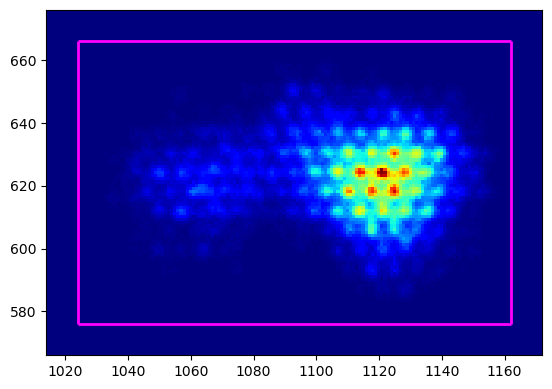

In [21]:
'''Lets plot a test image with a bounding box to test that we did it right'''
index = 15
tmp = ERs.iloc[index] #we'll plot frame 8
im = np.histogram2d(tmp['x'],tmp['y'],weights=tmp['q'],bins=(conf['cameraX'],conf['cameraY']),range=((0,conf['cameraX']),(0,conf['cameraY'])))[0].T
plt.imshow(im,cmap='jet')
plt.xlim(tmp['x'].min()-10,tmp['x'].max()+10)
plt.ylim(tmp['y'].min()-10,tmp['y'].max()+10)
xmin = (tmp['xBB']-tmp['width']/2)*conf['cameraX']
xmax = (tmp['xBB']+tmp['width']/2)*conf['cameraX']
ymin = (tmp['yBB']-tmp['height']/2)*conf['cameraY']
ymax = (tmp['yBB']+tmp['height']/2)*conf['cameraY']
plt.hlines(ymin,xmin,xmax,color='magenta',lw=2)
plt.hlines(ymax,xmin,xmax,color='magenta',lw=2)
plt.vlines(xmin,ymin,ymax,color='magenta',lw=2)
plt.vlines(xmax,ymin,ymax,color='magenta',lw=2)

### A reminder in case it isn't clear: the reason why we are able to generate bounding boxes like this is because we know the true boundaries of simulated tracks! This allows us to generate all labels automatically so we can train YOLO without hand labeling data

Now we will put our generated keypoints into the dataframe

In [22]:
'''Puts key point tuples into into columns p0 to pN'''
for key in coords.keys():
    ERs['p%s'%(key)] = coords[key]

In [23]:
'''Expands the tuples to p0x, p0y, p1x, p1y, etc.'''
# Initialize an empty dictionary to hold the new columns
new_columns = {}

# Iterate over each of the keypoint columns in the DataFrame
for col in ERs.columns[int(-1*conf['numKeyPoints']):]: #apologies that this is
    # Extract x and y components from each column
    ERs[[f'{col}x', f'{col}y']] = pd.DataFrame(ERs[col].tolist(), index=ERs.index)
    # Drop the original column
    ERs.drop(columns=[col], inplace=True)

### Don't forget to normalize the keypoints too!

In [24]:
for i in range(0,conf['numKeyPoints']):
    ERs['p%sx'%(i)] = ERs['p%sx'%(i)]/conf['cameraX']
    ERs['p%sy'%(i)] = ERs['p%sy'%(i)]/conf['cameraY']

In [25]:
'''Check the columns of our dataframe'''
ERs.columns

Index(['x', 'y', 'q', 'xvtx', 'yvtx', 'E', 'theta', 'phi', 'phid', 'thetad',
       'xhead', 'yhead', 'htlength', 'class_index', 'xBB', 'yBB', 'width',
       'height', 'p0x', 'p0y', 'p1x', 'p1y', 'p2x', 'p2y', 'p3x', 'p3y', 'p4x',
       'p4y', 'p5x', 'p5y', 'p6x', 'p6y'],
      dtype='object')

### Now let's generate image and label files for our training, validation, and test sets

### Step 0: Determine train / validation / test split. We're going to do this in the most rudimentary way. Scikit learn has a lot of information about good ways to do this that are worth looking up when you have the time. Here are a few examples:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

https://machinelearningmastery.com/k-fold-cross-validation/

In [26]:
'''I"m manually splitting the data up into 70% train, 20% validation, 10% test. There are better and more
statistically robust ways of doing this, like using k-fold cross validation which I linked an article on
above. You also ALWAYS want to shuffle your data before splitting it up. A lot of scikit-learn"s convenience
functions automatically shuffle for you but we"ll do it manually here'''

dataset_size = len(ERs)
# Shuffle data
ERs = ERs.sample(frac=1,random_state=42) #Random state ensures we get identical shuffles every time for reproducability
ERs.index = [i for i in range(0,len(ERs))] #reset index after shuffling
ERs['index'] = ERs.index
data = {} #dictionary storing train, validation, and test datasets
data['train'] = ERs[:int(dataset_size*0.7)]
data['valid'] = ERs[int(dataset_size*0.7):int(dataset_size*0.9)]
data['test'] =  ERs[int(dataset_size*0.9):]
print('Train set size: %s\nval set size : %s\ntest set size: %s\nsum : %s\ndataset size: %s'%(len(data['train']),len(data['valid']),len(data['test']),len(data['train'])+len(data['valid'])+len(data['test']),dataset_size))

Train set size: 782
val set size : 224
test set size: 112
sum : 1118
dataset size: 1118


### Step 1: Generate images. The reason why we normalize the bounding box and key point coordinates is so YOLO can be scale invariant. Scale invariance means that we can downsample an image by a uniform scale factor and the labels associated with this scaling will still be valid

Let's generate 4 x 4 images. This will reduce computational and memory expense by a factor of 16

In [27]:
conf

{'use_pretrained': True,
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'numKeyPoints': 7,
 'GPU': True,
 'project': '../models/raw_linear',
 'yoloConfigFile': '../configs/keypoint.yaml',
 'suffix': ''}

In [28]:
import matplotlib.image
def save_images(settype):
    
    if settype.lower() != 'train' and settype.lower() != 'test' and settype.lower() !='valid':
        raise ValueError("settype must be 'train','valid',or 'test'")
    
    path = '../datasets/%s%s/images'%(settype.lower(),conf['suffix'])
    
    #Create our output directory if it doesn't already exist
    if not os.path.exists(path):
        os.makedirs(path)
    
    for i in tqdm(range(0,len(data[settype.lower()]))):
        
        tmp = data[settype.lower()].iloc[i]
        
        '''Setting bins to (512,288) downsamples the image with 4x4 binning'''
        im = np.histogram2d(tmp['x'],tmp['y'],weights=tmp['q'],bins=(512,288),range=((0,2048),(0,1152)))[0].T
        
        '''The colorscale (vmin and vmax) as well as how we define im depend on if we use linear or logarithmic
        colorscale images'''
        if conf['log_scale'] == False:
            matplotlib.image.imsave('%s/%s.png'%(path,tmp['index']), im, vmin=0, vmax=35000,cmap = 'jet')
        else:
            im = np.log10(im+1)
            matplotlib.image.imsave('%s/%s.png'%(path,tmp['index']), im, vmin=0, vmax=4,cmap = 'jet')

In [29]:
'''Recall that master_configuration.yaml tells us if we"re using a log colorscale or not. This is built into the 
save_images function so the user doesn"t have to declare it here'''
for key in ['train','valid','test']:
    save_images(key)

100%|█████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 185.29it/s]


### Step 2: Generate labels

In [30]:
'''Ditto here: whether or not we use a log scale is determined from master_configuration.yaml'''
def save_labels(settype):
    if settype.lower() != 'train' and settype.lower() != 'test' and settype.lower() !='valid':
        raise ValueError("settype must be 'train','valid',or 'test'")

    path = '../datasets/%s%s/labels/'%(settype.lower(),conf['suffix'])
    
    if not os.path.exists(path):
        os.makedirs(path)

    for i in range(0,len(data[settype.lower()])):
        tmp = data[settype.lower()].iloc[i]
        series = tmp[['class_index','xBB', 'yBB', 'width','height', 'p0x', 'p0y', 'p1x', 'p1y', 'p2x', 'p2y', 'p3x', 'p3y', 'p4x','p4y', 'p5x', 'p5y', 'p6x', 'p6y']]
        with open(path+'%s.txt'%(tmp['index']), 'w') as f:
            series_str = ' '.join(map(str, series.values))
            f.write(series_str + '\n')
            f.close()

In [31]:
for key in ['train','valid']:
    save_labels(key)

### Step 3: Save our train, validation, and test dataframes for usage later

In [32]:
# Need to reset indices in order to save as feather
for key in ['train','valid','test']:
    data[key].index = [i for i in range(0,len(data[key]))]
    data[key].to_feather("../data/%s%s.feather"%(key,conf['suffix']))

# Now lets train YOLO (training will take a while. If you don't have access to a GPU, I would recommend leaving this script running overnight, or sending your data to Jeff so he can train it on a GPU)

In [33]:
conf

{'use_pretrained': True,
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'numKeyPoints': 7,
 'GPU': True,
 'project': '../models/raw_linear',
 'yoloConfigFile': '../configs/keypoint.yaml',
 'suffix': ''}

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8m-pose.yaml')  # load empty model. Can choose from yolov8{n,s,m,l,x}-pose.yaml. Letters are ordered from smallest model to largest
        
'''There are a lot of arguments for the train function that are not used here, so it may
be worth looking up some of the other options in the Ultralytics documentation for the 
train() function. master_configuration.yaml should handle some of these arguments pretty smoothly
but nevertheless, here are brief descriptions of the ones used here

data: A .yaml configuration file that lists important details of our keypoint data format and which
directories YOLO should extract images and labels from. You can view this file with your favorite text editor

epochs: Number of times the training script will loop over the entire dataset. It first loops through the
training set and then evaluates on the validation set. The validation metrics are what we use to determine
how well the model performs as its being trained. This is because the model isn"t trained on the validation set.

imgsz: The size of the maximum width of the image. We downsampled using 4 x 4 binning, thereby reducing the
2048 x 1152 images to 512 x 288.

rect: Setting this to true tells YOLO that these aren't square images and that it needs to measure the smaller
dimension scaled to the 512 we put in imgsz (this means it will automatically detect 288 pixels in y)

patience: This is an important training parameter more commonly called "early stopping" in ML parlance.
patience = 25 means that the algorithm will train until 25 successive epochs have elapsed where the model
didn't improve in a predefined metric (here its the average precision metric). In other words, if the model
didn"t "improve its learning on the validation set" after 25 epochs then it will terminate training. This is important to avoid
overtraining models.

device: Whether we train on CPU or GPU. Leave this field empty for now
'''

#Function to train YOLO
#The project field sets the directory where YOLO's trained weights will be assigned
model.train(data=conf['yoloConfigFile'],project=conf['project'],epochs=1000,patience=25,imgsz=512,rect=True)


Ultralytics YOLOv8.2.18 🚀 Python-3.10.14 torch-2.3.0+cpu CPU (AMD Ryzen 7 PRO 5875U with Radeon Graphics)
engine/trainer: task=pose, mode=train, model=yolov8m-pose.yaml, data=../configs/keypoint.yaml, epochs=1000, time=None, patience=25, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=../models/raw_linear, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=True, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

100%|█████████████████████████████████████████████████████████████| 755k/755k [00:00<00:00, 9.94MB/s]

Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[7, 2]

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  

 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   4338781  ultralytics.nn.modules.head.Pose             [1, [7, 2], [192, 384, 576]]  
YOLOv8m-pose summary: 320 layers, 26419405 parameters, 26419389 gradients, 81.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /home/jeff/workspace/migKeyPoint/datasets/train/labels... 782 images, 0 backgrounds, 

train: WARNING ⚠️ /home/jeff/workspace/migKeyPoint/datasets/train/images/291.png: ignoring corrupt image/label: negative label values [  -0.065833   -0.073148   -0.080463]
train: WARNING ⚠️ /home/jeff/workspace/migKeyPoint/datasets/train/images/730.png: ignoring corrupt image/label: negative label values [  -0.073238   -0.082072   -0.090905]
train: New cache created: /home/jeff/workspace/migKeyPoint/datasets/train/labels.cache
WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False



val: Scanning /home/jeff/workspace/migKeyPoint/datasets/valid/labels... 224 images, 0 backgrounds, 0 

val: New cache created: /home/jeff/workspace/migKeyPoint/datasets/valid/labels.cache


Plotting labels to ../models/raw_linear/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 83 weight(decay=0.0), 93 weight(decay=0.0005), 92 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to ../models/raw_linear/train
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     1/1000         0G      6.576      7.874          0       10.9      4.493         12        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        224        224          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     2/1000         0G      5.874      6.166          0      7.641       3.83         16        512: 

### We've now successfully used simulation to train YOLO to be a keypoint detector. Let's move to Part 2 and evaluate it on the test set